In [1]:
# import Libraries
from datetime import datetime #=> date time conversion on dataframe
import re
 
# Dataframe
import pandas as pd
 
# Numerical
import numpy as np
from math import sqrt
 
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns 
 
# Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, GRU , Dropout
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers.recurrent import GRU
from keras import optimizers
import tensorflow as tf
 
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
 
pd.options.mode.chained_assignment = None #https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html

In [2]:
#Open file and conversion date 
cpin = pd.read_csv('/Users/rendyhardjo/Downloads/Research Project/Raw Data/CPINJK.csv') #Read file
cpin['Date'] = pd.to_datetime(cpin['Date']) 
cpin #3785 rows × 7 columns

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-09-29,31.0,31.5,31.0,31.0,23.068253,75000.0
1,2005-09-30,32.5,32.5,32.0,32.5,24.184452,405000.0
2,2005-10-03,33.0,33.0,32.5,33.0,24.556522,6500000.0
3,2005-10-04,33.0,33.0,32.0,33.0,24.556522,1005000.0
4,2005-10-05,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3780,2020-12-22,6950.0,7000.0,6600.0,6650.0,6531.777832,7933200.0
3781,2020-12-23,6650.0,6825.0,6275.0,6600.0,6482.666504,7224400.0
3782,2020-12-28,6600.0,6800.0,6475.0,6775.0,6654.555176,6301400.0
3783,2020-12-29,6800.0,6850.0,6525.0,6600.0,6482.666504,7087700.0


In [3]:
start_from = np.min(cpin['Date'])
end = np.max(cpin['Date'])
print(f'{start_from} until {end}.')

2005-09-29 00:00:00 until 2020-12-30 00:00:00.


### Univariate Analysis => Decomposition

In [4]:
def get_date(df, start, end):
  '''
  Slicing dataframe
  '''
  date_format = '%Y-%m-%d'
  start_date = pd.to_datetime(start)
  end_date = pd.to_datetime(end)
  sliced_df = df[(df['Date']>=start_date) & (df['Date']<=end_date)]
  print(f"Starts from {np.min(sliced_df['Date'])} until {np.max(sliced_df['Date'])}.")
  return sliced_df

def visualize(df, variable):
  '''
  Fungsi untuk memvisualisasikan satu variabel saja
  matplotlib.pyplot as plt
  '''
  plt.figure(figsize=(10,4)) # Formatting ukuran
  plt.plot(df['Date'], df[variable], c='orange')
  plt.xlabel('Time')
  plt.ylabel('Value $')
  plt.title(variable)
  plt.show()


def multi_plot(df, combine_plot=False):
  '''
  Fungsi untuk memvisualisasikan OHLC secara terpisah 
  atau dikombinasikan

  parameter:
    df = Tahun yang akan divisualisasikan
    combine_plot = memvisualisasikan OHLC dalam satu plot

  Output:
    if combine_plot == True, maka output OHLC ditampilkan dalam satu plot
    if combine_plot == False, maka output OHLC ditampilkan secara terpisah
  '''
  fig, ax = plt.subplots(2, 2, figsize=(14, 6))
  variables = ['Open', 'High', 'Low', 'Close']
  colors = ['red', 'blue', 'purple', 'orange']
  index = 0
  for row in range(2):
    for col in range(2):
      ax[row][col].plot(df['Date'], df[variables[index]], c=colors[index])
      ax[row][col].set_xlabel('Time')
      ax[row][col].set_ylabel('Value $')
      ax[row][col].set_title(variables[index])
      index += 1

  fig.tight_layout()

  if combine_plot==True:
    plt.clf() # Delete visualisasi sebelumnya
    for variable, color in zip(variables, colors):
      plt.plot(df['Date'], df[variable].values, c=color, label=variable)
    plt.legend()
    plt.show()

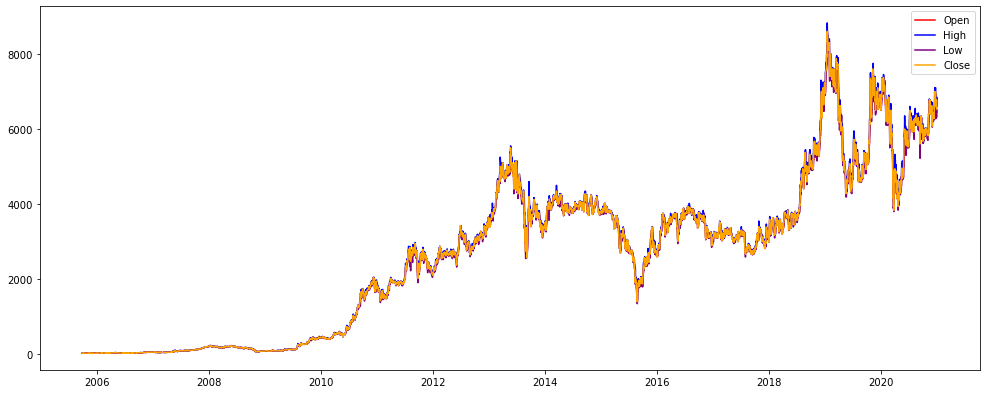

In [5]:
#cpin plot OHLC (Open High Low Close)
multi_plot(cpin, combine_plot=True)

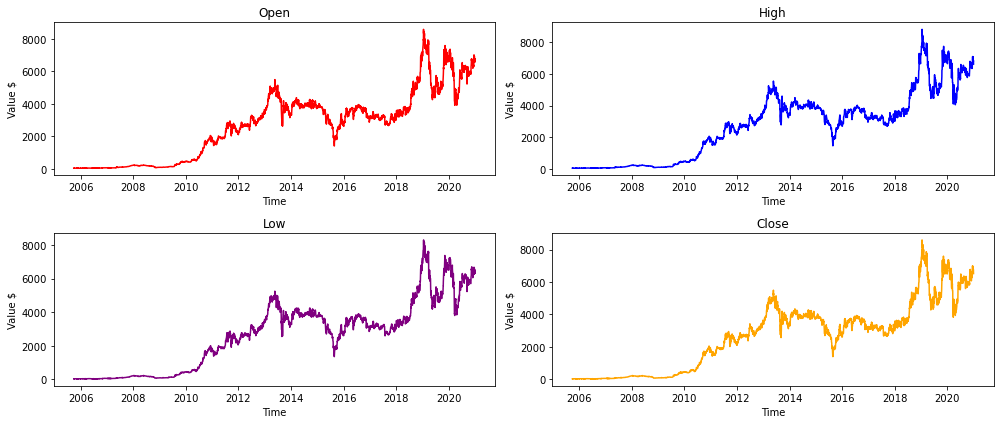

In [6]:
multi_plot(cpin)

In [7]:
# Temporary dataframe for testing the performance of the model (sample)
subset = get_date(cpin, '2005-9-29', '2020-12-31')
subset = subset.dropna(axis=0) # Need to drop NaN values (Temporary)
subset2 = cpin.interpolate() # fill NaN values with Interpolation

Starts from 2005-09-29 00:00:00 until 2020-12-30 00:00:00.


In [8]:
def split_datav1(year, variable, split_size=0.7, normalize=True): #3968x7 which train 70% around 2777, normalize because variance input
                                                                
  '''
  Tujuan split data adalah untuk melihat kinerja
  dari model dalam matrix accuracy regresi.

  Parameter:
    year = splited dataframe
    variable = OHLC variabel are using
    split_size = amount of training data to be used (in percent)
    normalize = The function will normalize the dataframe using MinMaxScaler sklearn
  
  Return:
    X_train = Feature (train data that will be used as a training feature)
    y_train = Label (train data that will be used as training targets)
    X_test = test data that will be used as a test feature
    y_test = test data that will be used as test targets target
    size = split data proportion
    mm_scaler = Scaling results from MinMaxScaler
  '''
  var = year.filter([variable])
  size = int(np.ceil(len(var)*split_size)) # angka split_size * row subset
  train = var[:size]
  test = var[size-60:] #sequence

  if normalize: # GRU is sensitive with the scale of the data, so I need to apply scaler like MinMax Scaler
    mm_scaler = MinMaxScaler(feature_range=(0, 1))
    train = mm_scaler.fit_transform(train)
    test = mm_scaler.transform(test) #bukan transform test, tapi transform train karena belum pemodelan

    # Visualize data train distribution
    plt.figure(figsize=(2, 4))
    sns.boxplot(data=train)
    plt.xlabel(variable)
    plt.ylabel('Normalized Value')
    plt.show()
  
  x_train = []
  y_train = []
  for i in range(60, len(train)):
    x_train.append(train[i-60:i, 0])
    y_train.append(train[i, 0])
  
  x_test = []
  y_test = []
  for i in range(60, len(test)):
    x_test.append(test[i-60:i, 0])
    y_test.append(test[i, 0])


  print(f'\n== Data distribution == \nX train: {len(x_train)} \ny train: {len(y_train)} \nX test: {len(x_test)} \ny test: {len(y_test)}')
  return np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test), size, mm_scaler

In [9]:
def split_datav2(year, variable, split_size=0.7, normalize=True): #it's the same as the data split above but the coding is different
  var = year.filter([variable])
  training_size = int(var.shape[0] * split_size)
  test_size = var.shape[0] - training_size
  X_train, X_test = var[:training_size], var[training_size:]

  if normalize: # GRU is sensitive with the scale of the data, so I need to apply scaler like MinMax Scaler
    mm_scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = mm_scaler.fit_transform(X_train)
    X_test = mm_scaler.transform(X_test)

  return X_train, X_test, training_size, mm_scaler

def create_dataset(dataset, time_step=5):
  '''
  time_step will be determined as an X_train, and it will be y_train
  example: prev values of X_train (before time_step) = 120, 130, 140, 150
           after we determined time_step: 3, it will grant first 3 data points as new X_train
           and the rest will be a y_train.
           So: new X_train = 120, 130, 140
                   y_train = 150 (predicted output as training data)
  '''
  data_X = []
  data_Y = []
  for i in range(len(dataset)-time_step-1):
    temp = dataset[i:(i+time_step), 0]
    data_X.append(temp)
    data_Y.append(dataset[i + time_step, 0])
  return np.array(data_X), np.array(data_Y)

In [10]:
def split_dataset(dataset, split_version='v2'):
  if split_version == 'v2':
    train_dataset, test_dataset, size, mm_scaler = split_datav2(dataset, 'Close')

    time_step = 5
    X_train, y_train = create_dataset(train_dataset, time_step=time_step)
    X_test, y_test = create_dataset(test_dataset, time_step=time_step)
    return X_train, X_test, y_train, y_test, size, mm_scaler

  else:
    X_train, X_test, y_train, y_test, size, mm_scaler = split_datav1(dataset, 'Close')
    return X_train, X_test, y_train, y_test, size, mm_scaler

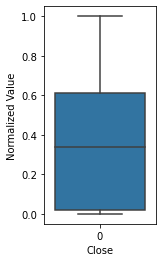


== Data distribution == 
X train: 2552 
y train: 2552 
X test: 1119 
y test: 1119


In [11]:
X_train, X_test, y_train, y_test, size, mm_scaler = split_dataset(subset, split_version='v1')

In [12]:
# Transform into 3 Dimensions (GRU prerequisite)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1], 1))

In [13]:
model = Sequential()

model.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(GRU(64, return_sequences=False))

model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(clipvalue=0.5, learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 32)            3264      
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 21,953
Trainable params: 21,953
Non-trainable params: 0
_________________________________________________________________


In [14]:
#train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=10)
model.save("/Users/rendyhardjo/Downloads/Research Project/CPIN/univariate.h5")

Epoch 1/10
40/40 [==============================] - 9s 109ms/step - loss: 0.1320 - val_loss: 0.3232
Epoch 2/10
40/40 [==============================] - 4s 95ms/step - loss: 0.0397 - val_loss: 0.0644
Epoch 3/10
40/40 [==============================] - 4s 95ms/step - loss: 0.0100 - val_loss: 0.0131
Epoch 4/10
40/40 [==============================] - 4s 93ms/step - loss: 0.0069 - val_loss: 0.0099
Epoch 5/10
40/40 [==============================] - 4s 93ms/step - loss: 0.0054 - val_loss: 0.0064
Epoch 6/10
40/40 [==============================] - 4s 92ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 7/10
40/40 [==============================] - 4s 93ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 8/10
40/40 [==============================] - 4s 100ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 9/10
40/40 [==============================] - 4s 90ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 10/10
40/40 [==============================] - 4s 90ms/step - loss: 0.0024 - val_loss: 0.0022


In [15]:
### PREDICTION
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

train_rmse = np.sqrt(np.mean(y_train_pred - y_train)**2) #RMSE
test_rmse = np.sqrt(np.mean(y_pred - y_test)**2)
print(f'Train Root Mean Squared Error (RMSE): {train_rmse.round(5)}')
print(f'Test Root Mean Squared Error (RMSE): {test_rmse.round(5)}')

Train Root Mean Squared Error (RMSE): 0.00026
Test Root Mean Squared Error (RMSE): 0.00944


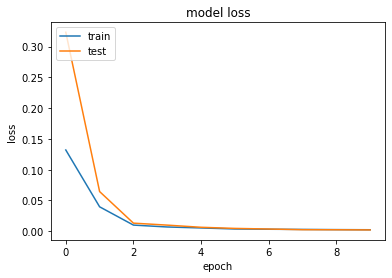

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() #for datasets 3968 rows x 4 

In [17]:
### BRING BACK TO ORIGINAL VALUE
train_predictions = mm_scaler.inverse_transform(y_train_pred)
test_predictions = mm_scaler.inverse_transform(y_pred)
y_train = mm_scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = mm_scaler.inverse_transform(y_test.reshape(-1, 1))

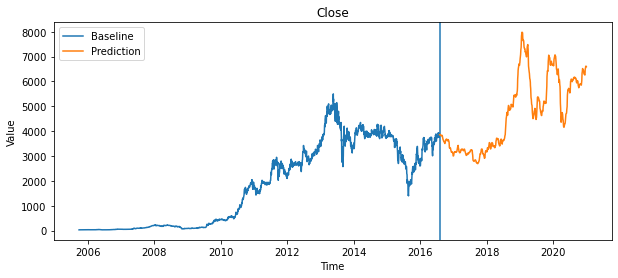

In [18]:
split_version = 'v1'

if split_version == 'v1':
  # take a real data from subset dataframe
  train = subset[:size] # Baseline
  valid = subset[size:] # data test
  # train.loc[:, 'predictions'] = train_predictions
  valid.loc[:, 'predictions'] = test_predictions
  # train['y_train'] = y_train
  valid['y_test'] = y_test

  # Visualize
  plt.figure(figsize=(10,4))
  plt.plot(train['Date'], train['Close'], label='Baseline')
  # plt.plot(train['Date'], train['predictions'], label='Train', c='r')
  plt.axvline(np.max(train['Date'])) # Garis batas
  plt.plot(valid['Date'], valid['predictions'], label='Prediction')
  # plt.plot(valid['Date'], valid['y_test'], label='Y test')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.title('Close')
  plt.legend()
  plt.show()

elif split_version=='v2':
  # Shift train predictions for plotting
  look_back = 100 # referenced from time_step
  trainPredictPlot = np.empty_like(Y06Y08)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(train_predictions)+look_back, :] = train_predictions

  # shift test predictions for plotting
  testPredictPlot = np.empty_like(Y06Y08)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(train_predictions)+(look_back*2)+1:len(Y06Y08)-1, :] = test_predictions

  # plot baseline and predictions 
  plt.figure(figsize=(8, 4))
  plt.plot(trainPredictPlot, c='g', label='Train data')
  plt.plot(testPredictPlot, c='b', label='Test data')
  plt.show()